### Calculate DG83 index
Method adapted from Pinheiro et al. (2019). This uses four thresholds to apply for the blocking criterea, which are applied in turn:
    
    AMPLITUDE - count the number of grid squares exceeding the var threshold (which may be -ve or +ve if one looks at the anomalies or not)
    AREA - for each blocked region count the number of grid cells at each latitude and so calculate the total area of each blocked region
    PERSISTENCE - measure how long the block persists for, and set a threshold for at least five days
    OVERLAP - count the number of days over which the contours for the blocked region overlap

If all of these criterea are met, then blocked_day = True. Else blocked_day = False.
    
These thresholds are applied to two datasets: 500hPa geopotentiel height anomalies, detrended wrt surface temperature (creating a measure similar to Dole and Gordon (1983)) and the seasonal anomaly of vertically averaged potential vorticity (similar to Schweirz (2004)).  The calculation of the anomaly fields and detrending has been done in a separate notebook, and uses ``cdo`` commands: https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf

In [1]:
#import iris
import netCDF4 as nc
import xarray
import numpy as np
import scipy
import glob
import matplotlib.pyplot as plt
#import PDF_funcs
import cartopy.crs as ccrs
from scipy import stats
from itertools import groupby
from operator import itemgetter
#for mapping the polygon on a sphere to a polygon on a flat surface to calculate area
import pyproj
import math
from shapely import geometry
import collections
from shapely.geometry import Point
from matplotlib.path import Path
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
S04=xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_era5_reanal_EUR_ssp585_JJAextd_1979-2019.nc")['TM90_clusters']

In [3]:
S04_ERA5 = xr.open_dataset(f"/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_fin_era5_reanal_EUR_JJAextd_1979-2019.nc")['TM90_clusters']>0

# 3. Apply the area threshold
For both DG83 (500hPa geopotential height anomaly) and S04 (VPV anomaly).

Define the relevant ``var_bool`` file depending on what one is calculating, and then the functions

In [4]:
def len_iter(items):
    return sum(1 for _ in items)

def consecutive_one(data):
    return max(len_iter(run) for val, run in groupby(data) if val)

In [5]:

def test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid):
    """
    test centroid position
    """
    if len([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid]) == 1:
        centroid_pos = ([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid][0])
        var_bool_blocked_idx[cluster[centroid_pos][0], cluster[centroid_pos][1]] = 2
        return True
    else:
        return False

def identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx):
    """
    Identify the location(s) of the centroid within the cluster
    function contains exception handling for if the centroid position (identified using the median lat/lon values)
    is not in the list
    Note that this has been written for a grid resolution of 2x2 - other grid resolutions e.g. 2.5x2.5 might have errors
    """
    try:
        centroid_pos = ([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid][0])
        var_bool_blocked_idx[cluster[centroid_pos][0], cluster[centroid_pos][1]] = 2
    except IndexError: #when the centroid_pos is not within the cluster (the median lat/lon value isn't part of the cluster)
        #need to adjust lat_centroid and lon_centroid until the closest centre within the cluster is identified
        centroid_not_found = True
        while centroid_not_found:
            for i in range(1,len(lat)):
                #loop through all possible centroid locations starting out from the median location
                #so that if there are two possible locations of the centroid within the cluster both are chosen
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid-i)
                if centroid_pos_found:
                    centroid_not_found = False #break loop here when the nearest neighbours have been checked
                #if still not found, look at the edge tiles
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid-i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid-i)
                if centroid_pos_found: #break loop here when the edge tiles have been checked before looping back through
                    centroid_not_found = False                    
                    
                    


In [6]:
#adapted from https://gis.stackexchange.com/questions/99917/converting-matplotlib-contour-objects-to-shapely-objects
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx+1

def area_test(var_bool_samp, lat, lon, area_thresh, lon_corr, area_cell, time_val, i):
    """
    Calculate the polygon shapes, determine the area for the blocked polygons and if there is a
    blocked polygon identify whether or not it passes the area_thresh threshold
    if so, then day is blocked
    #Length of 1 degree of Longitude = cosine (latitude in decimal degrees) * length of degree (miles) at equator
    #Each degree of latitude is approximately 69 miles (111 kilometers) apart
    #The range varies (due to the earth's slightly ellipsoid shape) from 68.703 miles (110.567 km) at the equator to 69.407 (111.699 km) at the poles    
    """
    blocked_day = 0
    
    #plt.pcolormesh(lon,lat,var_bool_samp)
    #CS = plt.contour(lon,lat,var_bool)# corner_mask=True,interpolation='none')
    #print(f"var_bool.sum() = {var_bool.sum()}")
    #plt.close()
    #plt.pcolormesh(lon,lat,var_bool)
    #fig=plt.figure()
    #plt.pcolormesh(lon,lat,var_bool)
    var_bool_blocked_idx = np.zeros((len(lat),len(lon)))#use to identify blocked regions
    cluster_num = 0

    var_bool_blocked_idx=xarray.DataArray(var_bool_samp*0, name = "TM90_clusters", coords=var_bool_samp.coords)
    #print(f"var_bool_blocked_idx = {var_bool_blocked_idx}")
    #calculate all of the clusters for this time step
    cluster_arr = calc_clusters(var_bool_samp, len(lat), len(lon))
    #print(f"var_bool_samp.sum() = {var_bool_samp.sum()}")
    for cluster in cluster_arr:
        #calculate the area of different clusters by projecting the lat/lon values onto a boolean lat/lon grid area_cell grid
        #and multiplying this by the area_cell grid to obtain the area
        
        #print(f"cluster = {cluster}")
        var_bool_cluster = np.zeros((len(lat),len(lon)))
        for lat_idx, lon_idx in cluster:
            #print(f"lat_idx, lon_idx = {lat_idx, lon_idx}")
            
            var_bool_cluster[lat_idx,lon_idx] = 1
        #fig = plt.figure()
        #plt.pcolormesh(lon,lat,var_bool_cluster)            
        #print(f"var_bool_cluster = {var_bool_cluster}")    
        area_cell_sum=(area_cell*var_bool_cluster).sum().values
        #plt.pcolormesh(lon,lat,area_cell) 
        #plt.colorbar()
        #print(f"var_bool_cluster.sum() = {var_bool_cluster.sum()}")
        #print(f"area_cell_sum = {area_cell_sum} km^2")
        #print(f"area_cell_sum_tot = {area_cell.sum().values} km^2")
        
        #if this area > area_thresh, add the cluster to the 2D lat/lon grid for overlap calculation
        if area_cell_sum > area_thresh:
            #print("BLOCKED")
            #label day as blocked
            cluster_num += 1
            blocked_day = 1
            for lat_idxs, lon_idxs in cluster:
                var_bool_blocked_idx[lat_idxs,lon_idxs]=1
            #label the centre lat, lon idx value with a 2
            lats_arr, lons_arr = ([i[0] for i in cluster], [i[1] for i in cluster])
            lat_centroid, lon_centroid = (np.median(lats_arr), np.median(lons_arr))
            # if there isn't a value in the middle then set the two neighbouring middle indices to 2 (effectively blur the two centroids)
            #otherwise there would be a bias to highlighting blicking in E/W or N/S directions
            if lon_centroid%1 == 0 and lat_centroid%1 == 0:  
                #print(lat_centroid, lon_centroid)
                #print(cluster)
                identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx)
            else: # if there isn't a value in the middle then set the two neighbouring middle indices to 2 (effectively blur the two centroids)
                if lat_centroid%1 != 0:
                    lat_centroid_arr = [lat_centroid-0.5, lat_centroid+0.5]
                    lon_centroid_arr = [lon_centroid, lon_centroid]
                if lon_centroid%1 != 0:
                    lat_centroid_arr = [lat_centroid, lat_centroid]
                    lon_centroid_arr = [lon_centroid-0.5, lon_centroid+0.5]
                if lon_centroid%1 != 0 and lat_centroid%1 != 0:    #when no middle lat or lon - create a centroid blob containing 4 tiles
                    lon_centroid_arr = [lon_centroid-0.5, lon_centroid+0.5, lon_centroid-0.5, lon_centroid+0.5]
                    lat_centroid_arr = [lat_centroid-0.5, lat_centroid+0.5, lat_centroid+0.5, lat_centroid-0.5]
                for lat_centroid, lon_centroid in zip(lat_centroid_arr, lon_centroid_arr):
                    identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx)
            
    return blocked_day, var_bool_blocked_idx, cluster_num

In [7]:
#run cell for TM90 calculations
TM902D_arr = sorted(glob.glob("/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/*"))
TM902D_arr = [f"/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/AGP/AGP_clusters_UKESM1-0-LL_r1i1p1f2_EUR_piControl_JJAextd_1960-2060.nc"]
lons_arr = [170-180,220-180]
lats_arr = [30,76]
domain = "EUR"
grid_res = 2
lat_str, lon_str = "lat", "lon"
#xarray.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/TM902D_AWI-CM-1-1-MR_r1i1p1f1_EURATL_ssp585_JJAextd_2015-2100tot.nc")['TM902D']
#xarray.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/TM902D_AWI-CM-1-1-MR_r1i1p1f1_EURATL_ssp585_JJAextd_2015-2100tot.nc")['TM902D']
var_bool = xarray.open_dataset(TM902D_arr[0])['TM90_clusters'].sel(lon=np.arange(lons_arr[0],lons_arr[1]+grid_res,grid_res),
                                                            lat=np.arange(lats_arr[0],lats_arr[1]+grid_res,grid_res))
lat, lon = var_bool[lat_str], var_bool[lon_str]
#these variables can be modified
area_thresh = 1e6 # minimum blocked area in km^2
# 1e6 km^2 is a reasonable minimum area since this is approximately the squared radius of a typical anticyclone (pg 10 of Hoskins & James)
#grid_res = 1 #grid resolution
#create a tuple of the lat/lon coordinates of the grid to test whether or not the grid cells exist within the point
lats, lons = np.asarray(np.meshgrid(lat,lon))[0,:,:].flatten(), np.asarray(np.meshgrid(lat,lon))[1,:,:].flatten()
grid_coords = list(zip(lats,lons-180))
#rough minimum for the number of grid cells needed for a blocking event
min_num_grid_cells=area_thresh*np.cos(np.radians(30))/(grid_res*grid_res*110*110) #0.25x0.25 grid x 110km (roughly 1/360 of Earth's circumference)
#minimum proportion of grid cells to block
prop_blocked_thresh = min_num_grid_cells/(len(lat)*len(lon))

In [8]:

#note that for this dataset this cell takes a long time (several minutes) to run
var = "500zg"
blocked_day_arr = np.zeros((len(var_bool['time'])))
#save the block_arr_area and blocked_idx_vals files
#this gives information about the index values that are blocked on that day, which will be used when applying the overlap threshold
for TM902D_str in TM902D_arr[:1]:
    var_bool = xarray.open_dataset(TM902D_str)['TM90_clusters'].sel(lon=np.arange(lons_arr[0],lons_arr[1]+grid_res,grid_res),
                                                             lat=np.arange(lats_arr[0],lats_arr[1]+grid_res,grid_res))
    time, lat, lon = var_bool['time'], var_bool[lat_str], var_bool[lon_str]    
    lon_corr = [True if var_bool[lon_str].max() > 180 else False][0]
    if lon_corr:
        lon = lon - 180
    mdl, ens, styr, endyr = TM902D_str.split("_")[2], TM902D_str.split("_")[3], TM902D_str.split("_")[-1][:4], TM902D_str.split("_")[-1][5:9]
    #create a DataArray where each element corresponds to the area of that cell
    area_cell=xr.DataArray(var_bool[0,:,:],name = "grid_cell_area")*0+1
    area_cell[:,:] = area_cell[:,:]*(np.cos(np.radians(var_bool[lat_str][:]))*111*grid_res)*(111*grid_res)    
    print(mdl,ens,styr,endyr)
    var_bool_blocked_arr = []
#     for i in range(time.shape[0]):
#         if i%100 == 0:
#             print(i)
#         blocked_day_arr[i], var_bool_blocked, cluster_num = area_test(var_bool[i,:,:], lat, lon, area_thresh, lon_corr, area_cell, var_bool['time'][i], i)
#         #fig = plt.figure()
#         #plt.pcolormesh(lon,lat,var_bool_blocked)
#         ##var_bool_samp, lat, lon, area_thresh, lon_corr, area_cell, time_val
#         var_bool_blocked_arr.append(var_bool_blocked)
#     var_bool_blocked_clusters = xarray.concat(var_bool_blocked_arr, dim='time')
#     var_bool_blocked_clusters.to_netcdf(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_{mdl}_{ens}_{domain}_ssp585_JJAextd_{styr}-{endyr}.nc")
    
        
# datasets = []
# for example in examples:
#     ds = create_an_xarray_dataset(example)
#     datasets.append(ds)
# combined = xarray.concat(datasets, dim='example')
       # the block_data files saves the data for each day for the particular indices that are blocked
        ##np.savetxt(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/blocked_idx_vals/{var}_{mdl}_{ens}_{styr}_{endyr}_%05d.txt"%i, var_bool_blocked[0])
        #if blocked_day == 1:
        #    blocked_day_arr[i] = 1

#TM90_idx_xr = xarray.DataArray(blocked_day_arr, name = "TM90_idx", dims = ("TM90_idx"), coords=[('time', time)])       
#TM90_idx_xr.to_netcdf(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM902D_blockdata_{mdl}_{ens}_{domain}_ssp585_JJAextd_{styr}-{endyr}.nc")


clusters UKESM1-0-LL 1960 2060


# 4. Apply the persistence criterea
This is defined and then applied both before and after the overlap criterea

In [9]:
def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------    
    Output : 1D Array of indices in the input array that satisfy the 
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    from https://stackoverflow.com/questions/36522220/searching-a-sequence-in-a-numpy-array
    """

    # Store sizes of input array and sequence
    Na, Nseq = len(arr), len(seq)

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found


# 5. Apply the overlap criterea

In [13]:

def get_adjacent_indices(i, j, m, n):
    """
    Obtain the adjacent indices where they can be found
    uses the nearest neighbour
    from https://stackoverflow.com/questions/51657128/how-to-access-the-adjacent-cells-of-each-elements-of-matrix-in-python/51657232
    """
    adjacent_indices = []
    if i > 0:
        adjacent_indices.append((i-1,j))
    if i+1 < m:
        adjacent_indices.append((i+1,j))
    if j > 0:
        adjacent_indices.append((i,j-1))
    if j+1 < n:
        adjacent_indices.append((i,j+1))
    return adjacent_indices

def add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals, lat_lon_idx_vals, len_lat, len_lon):
    """
    If not already in the cluster, add adjacent values to the cluster
    """
    if ((lat_idx, lon_idx)) not in cluster:
        #print(f"{(lat_idx, lon_idx)} added to cluster")
        cluster.append((lat_idx, lon_idx))
    adjacent_indices = get_adjacent_indices(lat_idx, lon_idx, len_lat, len_lon)
    #print(f"adjacent_indices = {adjacent_indices}")
    for adj_idx in adjacent_indices:
        if adj_idx in lat_lon_idx_vals:
            if adj_idx not in cluster:
                #add the value and the adjacent values to the cluster
                cluster.append(adj_idx)  
                if adj_idx not in idx_vals:
                    idx_vals.append(adj_idx) # these are the new index values that are going to be iterated over again

    return idx_vals
            
def calc_clusters(var_bool, len_lat, len_lon):
    """
    Returns a list of grouped clusters using the nearest neighbour
    """
    lat_idx_vals, lon_idx_vals = np.where(var_bool > 0)
    lat_lon_idx_vals = [(lat_idx, lon_idx) for lat_idx, lon_idx in zip(lat_idx_vals, lon_idx_vals)]
    cluster, cluster_arr = [], []
    #print(lat_lon_idx_vals)
    for i in range(lon_idx_vals.shape[0]):
        #print(i)
        #need to find in the whole array if there are any matching index values that are adjacent and haven't already been put into the cluster
        lat_idx, lon_idx = lat_lon_idx_vals[i]
        #print(lat_idx, lon_idx)
        if sum([(lat_idx, lon_idx) in cluster for cluster in cluster_arr]) == 0: #check if lat or lon index already in a cluster
            cluster, idx_vals = [], []
            idx_vals = add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals, lat_lon_idx_vals, len_lat, len_lon)
            num_idx_vals = len(idx_vals) # number of idx vals in cluster not looped across yet
            #print(f"num_idx_vals = {num_idx_vals}")
            idx_vals_old, idx_vals_new = idx_vals.copy(), idx_vals.copy()
            while (num_idx_vals > 0): # while there are still index values in the nearest neighbour
                #loop through all the adjacent values that are also blocked
                for lat_idx, lon_idx in (idx_vals_old):
                    #for each adjacent value that is also blocked, identify the new index values
                    idx_vals_new = add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals_new, lat_lon_idx_vals, len_lat, len_lon)
                    #remove the idx_val that has been looped over from the list
                    idx_vals_new.remove((lat_idx, lon_idx))                
                idx_vals_old = idx_vals_new.copy()
                #print(f"num_idx_vlas = {len(idx_vals_old)}")
                num_idx_vals = len(idx_vals_old)
                #if num_idx_vals == 0:
                    #print("HERE")
                    #break
            cluster_arr.append((cluster))
        else:
            pass #here if current index in loop is already in a cluster

    return cluster_arr    
    

In [14]:
#to apply the persstence critereon, need to remove all events that don't persist over a period of five days
#any sequence of 1,1,1,1,1 or more is fine, but 0,1,1,1,1,0 or less must be removed
#sequences to be removed: 0,1,1,1,1,0; 0,1,1,1,0; 0,1,1,0; 0,1,0
#note that Verdecchia et al (1996) add some criterea for blocking to be removed
def persistence_criterea(block_vals_arr, JJA_days, var_bool_blocked_clusters, var_bool_blocked_str, persis_thresh=5):
    """
    Apply the persistence criterea to a list of days which are blocked or not
    by removing the sequences for days which are not blocked
    persis_thresh is the minimum number of blocked days for the threshold (at least 2)
    block_arr is an array of True/False days of blocking
    No padding here - assuming that data is stored from 26th May - 6th September
    
    NB this function is only used for removing blocked days that are clearly isoalted in the period i.e. where 0% of grid cells are blocked for a period of less than five days
    
    This way of working means that the criterea are applied to the CLUSTERS and then whether or not a day is blocked is identified (over N/S/E/W Europe or across whole domain)
    """
    #set the first day of each set to zero
    block_arr_persis = block_vals_arr.values
    block_arr_persis[0::JJA_days] = 0
    var_bool_blocked_clusters[var_bool_blocked_str][0::JJA_days,:,:] = var_bool_blocked_clusters[var_bool_blocked_str][0::JJA_days,:,:]*0
    block_arr_persis[-1] = 0 #make last day (6th Sep) also zero
    var_bool_blocked_clusters[var_bool_blocked_str][-1,:,:] = 0
    #blocking sequences to be removed
    seq_arr = [[0,1,0], [0,1,1,0], [0,1,1,1,0], [0,1,1,1,1,0], [0,1,1,1,1,1,0]]
    seq_to_remove_arr = seq_arr[:persis_thresh-1]
    for seq in seq_to_remove_arr:
        seq_idx=search_sequence_numpy(block_arr_persis,seq)
        block_arr_persis[seq_idx] = 0
        for idx in seq_idx:
            var_bool_blocked_clusters[var_bool_blocked_str][idx,:,:] = 0      
#     block_idx_xr_persis = xarray.Dataset(
#     { block_idx_str: (("time"), block_arr_persis)},
#         coords={"time": block_idx_xr['time'].values}
#      )
    return block_arr_persis, var_bool_blocked_clusters

In [66]:
AGP=xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_fin_UKESM1-0-LL_r1i1p1f2_piControl_EUR_JJAextd_1960-2060.nc")['TM90_clusters']

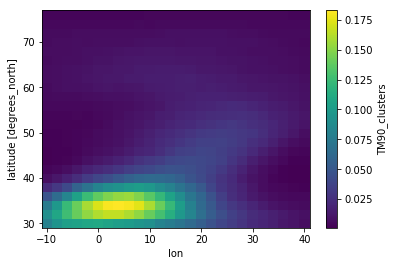

In [67]:
AGP.mean(axis=0).plot()

In [15]:
#potentially helpful: https://stackoverflow.com/questions/55641425/check-if-two-contours-intersect
def overlap_persistence_clusters(var_cluster, var_cluster_str, lat_str, lon_str, persistence_thresh=5):
    """
    Calculates the overlap and persistence criterea for each of the clusters
    """
    #first remove all the instances where there are clearly isolated clusters
    blocked_vals_arr = var_cluster.sum(dim=lat_str).sum(dim=lon_str)>0
    JJA_days=int(var_cluster['time.dayofyear'].max()-var_cluster['time.dayofyear'].min())
    #print(f"before persis, blocked_vals_arr.sum(), var_blocked_clusters.sum() = {blocked_vals_arr.sum(), var_cluster.sum()}")    
    blocked_vals_arr, var_cluster = persistence_criterea(blocked_vals_arr[var_cluster_str], JJA_days, var_cluster, var_cluster_str)
    #print(f"after persis, blocked_vals_arr.sum(), var_blocked_clusters.sum() = {blocked_vals_arr.sum(), var_cluster.sum()}") 
    len_time, len_lat, len_lon = var_cluster[var_cluster_str].shape[0], var_cluster[var_cluster_str].shape[1], var_cluster[var_cluster_str].shape[2]  

    
    #need to group clusters together that are matched and eliminate them if they don't last more than five days
    #assign a means of uniquely identifying each cluster by labelling one of the points in the cluster with a unique number >2
    #if this number doesn't persist for longer than persis_thresh, eliminate the cluster
    
    
    #loop through each day
    #identify the clusters for that particular day
    #set for each cluster identified on that day
    #see how long that cluster persists for
    #by looking at the clusters in the next day in the dataset and so on until a cluster is identified which doesn't overlap with that cluster
    #for each cluster that matches, store them in a new xarray
    #if the number of days that that cluster persists over is greater than persis_thresh, input the time,lat,lon coords into the new xarray
    #for each subseuqnt cluster, check if there is an overlap with the next day
    #If there is an overlap with the next day AND that cluster is already stored in the new xarray
    #then don't need to iterate over whole time series but add new points to new xarray
    #this then mixes both the persistence and overlap criterea on a per cluster basis, but it may be very slow 
    #create two copies of var_blocked_clusters
    var_cluster_indiv = var_cluster.copy()*0 # used to store clusters as they are tested to see  
    var_cluster_indiv_next_day = var_cluster.copy()*0
    var_cluster_indiv_sum = var_cluster.copy()*0
    var_cluster_fin = var_cluster.copy()*0 # what the final clusters are added to
    var_cluster_bool = ((var_cluster[var_cluster_str][:,:,:] > 0)+1-1) #set all centroids to 1 for overlap calculation (although should probably set the centroid calculation after this)
    cluster_persis_vals_arr, cluster_persis_timestr_idx_arr = [], [] # store xarray datasets for each cluster's persistence and start date index
    for i in range(len_time):
    #range(0,20):# range(len_time):
        #if i%100 == 0:
        #    print(f"i = {100*i/len_time}")
        #print(int(var_cluster[var_cluster_str][i,:,:].sum()))
        if (var_cluster[var_cluster_str][i,:,:].sum()) > 0:
            #print(f"i = {i}")
            #identify the clusters for that particular day
            cluster_arr = calc_clusters(var_cluster[var_cluster_str][i,:,:], len_lat, len_lon)
            #for each cluster identified on that day, see how long that cluster persists for
            for cluster in cluster_arr:
                #to calculate the persistence for each blocking event, measure separately how persistent the cluster is
                #and over what days the cluster is persisting
                cluster_persis = 1 #counter for the number of days across which the cluster persists
                clusters_merged = False # condition for if the current clsuter will merge with a cluster already saved
                for lat_idx, lon_idx in cluster:
                    #print(f"lat_idx, lon_idx = {lat_idx, lon_idx}")
                    #add the cluster to the individual set of clusters
                    var_cluster_indiv[var_cluster_str][i,lat_idx,lon_idx] = 1
                #check if the day's cluster has already been added to the dataset    
                #var_blocked_clusters_sum = (var_cluster_indiv[var_cluster_str][i,:,:]*var_cluster_fin[var_cluster_str][i,:,:]).sum()
                overlap = True
                #if (var_cluster_indiv[var_cluster_str][i,:,:]*var_cluster_fin[var_cluster_str][i,:,:]).sum() == 0: #if cluster has not yet been added to the dataset
                while overlap:
                    for j in range(0,JJA_days+1): # maximimum possible value is JJA_days since as above the edges of each year have been set to zero
                        #print(f"j = {j}")
                        #if (var_cluster[var_cluster_str][i+j+1,:,:].sum() == 0):
                        #    print("next var_cluster = zero")
                        var_blocked_clusters_sum = var_cluster_indiv[var_cluster_str][i+j,:,:]*var_cluster[var_cluster_str][i+j+1,:,:]
                        if (var_blocked_clusters_sum.sum() > 0): #current cluster overlaps with a cluster on the next day
                            #print("current cluster overlaps with a cluster on the next day")
                            #calculate the cluster for the next day
                            next_day_cluster_arr = calc_clusters(var_cluster[var_cluster_str][i+j+1,:,:], len_lat, len_lon)
                            matching_cluster_found = False
                            #identify which cluster of the next day matches the cluster of the previous day
                            for next_day_cluster in next_day_cluster_arr:
                                for lat_idx, lon_idx in next_day_cluster:
                                    var_cluster_indiv_next_day[var_cluster_str][i+j+1,lat_idx,lon_idx] = 1
                                var_blocked_clusters_sum = var_cluster_indiv[var_cluster_str][i+j,:,:]*var_cluster_indiv_next_day[var_cluster_str][i+j+1,:,:]
                                if (var_blocked_clusters_sum.sum() != 0):
                                    #current cluster within the clusters of the next day matches the cluster of the current day
                                    #print("current cluster within the clusters of the next day matches the cluster of the current day")
                                    var_cluster_indiv[var_cluster_str][i+j+1,:,:]=var_cluster_indiv_next_day[var_cluster_str][i+j+1,:,:]
                                    matching_cluster_found = True
                                    cluster_persis += 1 #add one more day to the persistence of the cluster
                                    break #can exit loop here since don't need to search through all subsequent clusters
                            if matching_cluster_found:
                                #check if the matching cluster that has been found for the next day is already a cluster that has been stored in the final set of clusters
                                var_blocked_clusters_sum = var_cluster_indiv[var_cluster_str][i+j+1,:,:]*var_cluster_fin[var_cluster_str][i+j+1,:,:]
                                if (var_blocked_clusters_sum.sum() != 0):
                                    #in which case the cluster for the next day doesn't need to be added
                                    #print("cluster for the next day doesn't need to be added")
                                    clusters_merged = True
                                    #var_cluster_indiv[var_cluster_str][i+j+1,:,:] = var_cluster_indiv[var_cluster_str][i+j+1,:,:]*0
                                    #but the loop can be exited and the cluster for the current day and persistence will still be added
                                    #NB this means that you may find clusters which have lengths shorter than the persistence criterea
                                    #since they have been joined to larger blocking events
                                    #the alternative is to potentially double count one blocking event several times
                                    #such events could be discarded from the final set of persistence criterea statistics                                    
                                    overlap = False
                                    break
                            if matching_cluster_found == False:
                                #print("no matching cluster was found with the next day, so there is no more overlap")
                                #no matching cluster was found with the next day, so there is no more overlap
                                overlap = False
                                break #need breaks here to exit out of the for loop and check the condition for the while loop
                        else: #current cluster doesn't overlap with next cluster
                            #print("current cluster doesn't overlap")
                            overlap = False
                            break
                        overlap = False

                    #print(f"cluster_persis = {cluster_persis}")
                    #print(f"clusters_merged = {clusters_merged}")
                    if cluster_persis > persistence_thresh or clusters_merged:
                        #if the cluster is longer than persistence or was merged into such a cluster, add to the final set
                        #print("add to final set")
                        #var_cluster_indiv_add=var_cluster_indiv[var_cluster_str].where((var_cluster_indiv[var_cluster_str] > 0) | (var_cluster_fin[var_cluster_str] == 0))
                        #print(var_cluster_indiv_add.sum())
                        #print(var_cluster_indiv_add)
                        #x.astype(int)
                        #var_cluster_indiv_add_mult=(var_cluster_indiv_add.astype("float64"))*var_cluster[var_cluster_str]
                        #print(var_cluster_indiv[var_cluster_str]>0 and var_cluster_fin[var_cluster_str] == 0)
                        #var_cluster_fin[var_cluster_str] += var_cluster_indiv_add.astype("float64")*var_cluster[var_cluster_str] #multiply by original to obtain centroid points
                        
                        #var_cluster_fin[var_cluster_str]+=var_cluster_indiv[var_cluster_str]
                        var_cluster_indiv_sum[var_cluster_str]+=var_cluster_indiv[var_cluster_str]
                        #var_cluster_fin[var_cluster_str]+var_cluster_indiv_add_mult.astype("float64")
                        #((var_cluster_indiv[var_cluster_str]>0)+1-1)*var_cluster[var_cluster_str] #multiply by original to obtain centroid points
                        
                        #store the cluster start dates and persistence in another xarray
                        #note that this will include blocking evenst that began late May or ended late July
                        #when plotting persistence/max duration of summer blocking events such events could be included if desired
                        #these could be included so that the max duration and persistence statistics are not unduly skewed
                        #store day on which the cluster began
                        cluster_persis_vals_arr.append(cluster_persis)
                        cluster_persis_timestr_idx_arr.append(i)
                    #set to zero to eliminate clusters already counted or clusters not persistent enough to be considered
                    var_cluster_indiv[var_cluster_str] = var_cluster_indiv[var_cluster_str]*0
    #cluster_persis_xr = xarray.concat(cluster_persis_arr, dim='time')
    
    var_cluster_fin[var_cluster_str] = ((var_cluster_indiv_sum[var_cluster_str]>0)+1-1)*var_cluster[var_cluster_str] #multiply by original to obtain centroid points
    
    if len(cluster_persis_vals_arr) > 0:
        cluster_persis_arr_xr = xarray.Dataset(
                        { "cluster_persis": cluster_persis_vals_arr},
                           coords={"time": var_cluster['time'][cluster_persis_timestr_idx_arr]}
                        )
    else:
        #no blocking has been identified for this period
        cluster_persis_arr_xr = xarray.Dataset(
                        { "cluster_persis": np.zeros((var_cluster['time'].shape[0]))},
                           coords={"time": var_cluster['time']}
                        )
    return var_cluster_fin, cluster_persis_arr_xr
    


In [17]:
var_bool_blocked_clusters=xr.open_dataset('/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_UKESM1-0-LL_r1i1p1f2_piControl_EUR_UKESM1-0-LL_JJAextd_new.nc')#['TM90_clusters']
#("/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/DG83/DG83_clusters_UKESM1-0-LL_r1i1p1f2_piControl_EUR_ssp585_JJAextd_1960-2060.nc")#['TM90_clusters']
#xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_UKESM1-0-LL_r1i1p1f2_piControl_EUR_UKESM1-0-LL_JJAextd.nc")
#xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_data_day_EUR_era5_JJAextd.nc")
#xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/DG83/block_data/DG83_clusters_era5_reanal_EUR_ssp585_JJAextd_1979-2019.nc")
                                          #rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_era5_reanal_EUR_ssp585_JJAextd_1979-2019.nc#['TM90_clusters']
#xarray.open_dataset(f"/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/DG83/DG83_clusters_UKESM1-0-LL_r1i1p1f2_EUR_piControl_JJAextd_1960-2060.nc")
                                              
var_bool_blocked_str = "TM90_clusters"
lat_str, lon_str = "lat", "lon"
#issues with 2011 and 2039 for UKESM AGP- probably these years don't have any blocked events observed?
for year in range(1960,2061):
    print(year)
    var_bool_blocked_clusters_sel = var_bool_blocked_clusters.sel(time=np.isin(var_bool_blocked_clusters['time.year'], [year]))
    #print(var_bool_blocked_clusters_sel.sum())
    var_cluster_fin, cluster_persis = overlap_persistence_clusters(var_bool_blocked_clusters_sel, var_bool_blocked_str, lat_str, lon_str)
    var_cluster_fin.to_netcdf(f"/rds/general/user/cmt3718/home/data/AGP/AGP_clusters_fin_era5_reanal_piControl_EUR_JJAextd_{year}.nc")
#(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_fin_AWI-CM-1-1-MR_r1i1p1f1_EUR_ssp585_JJAextd_2015-2100.nc")
    cluster_persis.to_netcdf(f"/rds/general/user/cmt3718/home/data/AGP/AGP_clusters_persis_era5_reanal_piControl_EUR_JJAextd_{year}.nc")
#(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_persis_AWI-CM-1-1-MR_r1i1p1f1_EUR_ssp585_JJAextd_2015-2100.nc")

1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [14]:
DG83=xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/DG83/DG83_clusters_fin_UKESM1-0-LL_r1i1p1f2_piControl_EUR_JJAextd_1960-2060.nc")['TM90_clusters']

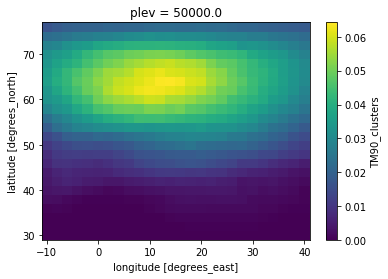

In [16]:
DG83.mean(axis=0).plot()

In [ ]:

cdo mergetime *AGP_clusters_persis*  AGP_clusters_persis_UKESM1-0-LL_r1i1p1f2_piControl_EUR_ssp585_JJAextd_1960-2060.nc

AGP_clusters_persis_UKESM1-0-LL_r1i1p1f2_piControl_EUR_ssp585_JJAextd_1960-2060.nc

cp AGP_clusters_UKESM1-0-LL_r1i1p1f2_piControl_EUR_UKESM1-0-LL_JJAextd_new.nc /rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/AGP

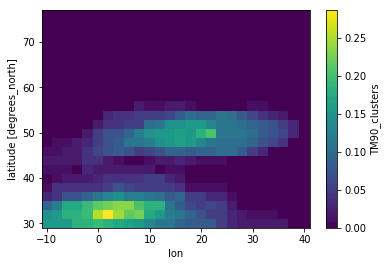

In [31]:
var_cluster_fin['TM90_clusters'].mean(axis=0).plot()

In [ ]:
var_bool_blocked_clusters_str_arr=["/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_BCC-CSM2-MR_r1i1p1f1_EUR_ssp585_JJAextd_1950-2100.nc",
"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_BCC-ESM1_r1i1p1f1_EUR_ssp585_JJAextd_1950-2014.nc",
"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_CESM2-FV2_r1i1p1f1_EUR_ssp585_JJAextd_1850-2000.nc"]

var_cluster_fin_str_arr=["/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_fin_BCC-CSM2-MR_r1i1p1f1_EUR_ssp585_JJAextd_1950-2100.nc",
"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_fin_BCC-ESM1_r1i1p1f1_EUR_ssp585_JJAextd_1950-2014.nc",
"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_fin_CESM2-FV2_r1i1p1f1_EUR_ssp585_JJAextd_1850-2000.nc"]

var_cluster_persis_str_arr=["/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_persis_BCC-CSM2-MR_r1i1p1f1_EUR_ssp585_JJAextd_1950-2100.nc",
"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_persis_BCC-ESM1_r1i1p1f1_EUR_ssp585_JJAextd_1950-2014.nc",
"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_persis_CESM2-FV2_r1i1p1f1_EUR_ssp585_JJAextd_1850-2000.nc"]

var_bool_blocked_str = "TM90_clusters"
lat_str, lon_str = "lat", "lon"

for var_bool_blocked_clusters_str, var_cluster_fin_str, var_cluster_persis_str in zip(var_bool_blocked_clusters_str_arr, var_cluster_fin_str_arr, var_cluster_persis_str_arr):
    var_cluster_fin, cluster_persis = overlap_persistence_clusters(var_bool_blocked_clusters, var_bool_blocked_str, lat_str, lon_str)
    var_cluster_fin.to_netcdf(var_cluster_fin_str)
    cluster_persis.to_netcdf(var_cluster_persis_str)


In [23]:
xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/TM90/block_data/overlap_persis/TM90_clusters_fin_reanal_EUR_EUR_ssp585_JJAextd_1979-2019.nc")

<xarray.Dataset>
Dimensions:        (latitude: 24, longitude: 26, time: 4264)
Coordinates:
  * latitude       (latitude) float32 30.0 32.0 34.0 36.0 ... 72.0 74.0 76.0
  * longitude      (longitude) float32 170.0 172.0 174.0 ... 216.0 218.0 220.0
  * time           (time) datetime64[ns] 1979-05-26T10:30:00 ... 2019-09-06T10:30:00
Data variables:
    TM90_clusters  (time, latitude, longitude) int64 ...

In [ ]:
/rds/general/user/cmt3718/home/data/reanal/TM90/block_data/overlap_persis/TM90_clusters_fin_reanal_EUR_EUR_ssp585_JJAextd_1979-2019.nc
/rds/general/user/cmt3718/home/data/reanal/DG83/block_data/DG83_clusters_era5_reanal_EUR_ssp585_JJA_1979-2019.nc
/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_era5_reanal_EUR_rcp85_JJA_1979-2019_neg.nc

In [29]:
    
def sel_JJA_extd(da):
    """
    Selects the JJA extd period +- 5 days.
    """
    da_MJJAS=da.sel(time = np.isin(da['time.month'], np.arange(5,10)))
    da_JJAextdS=da_MJJAS.sel(time=~(((da_MJJAS.time.dt.month == 5) & (da_MJJAS.time.dt.day < 28))))
    da_JJAextd=da_JJAextdS.sel(time=~(((da_JJAextdS.time.dt.month == 9) & (da_JJAextdS.time.dt.day > 4))))
    return da_JJAextd
    

In [32]:
def da_lon_adj(da):
    """
    Reset the longitude coordinates if they are defined from 0-360 E to -180 - 180 E.
    """
    #identify label for the longitude coordinate
    if "longitude" in str(da.coords):
        lon_str = "longitude"
    else:
        lon_str = "lon"
    if int(da[lon_str].max()>180):
        #calculate longitude resolution
        lon_diff = abs(int(da[lon_str][1]-da[lon_str][0]))
        #redefine 0-360 degrees E to -180 - +180 deg E
        lon_adj = da[lon_str]*(da[lon_str]<(180+lon_diff/2))+((da[lon_str]-360)*(da[lon_str]>180))
        da[lon_str] = lon_adj
        # number of indices that lat idx should be mvoed by
        if da[lon_str][0] == 0:
            lat_idx_roll = int(len(da[lon_str])/2)
        else:
            print("ERROR - coordinate system doesn't start from 0 degrees east")
            return da
    
        if lon_str == "lon":
            da_roll = da.roll(lon = lat_idx_roll, roll_coords=True)
        if lon_str == "longitude":
            da_roll = da.roll(longitude = lat_idx_roll, roll_coords=True)     
        #check that the output longitude coordinates are in ascending order
        if False not in np.array(da[lon_str].values == da[lon_str].sortby(lon_str, ascending=True).values):
            return da_roll
        else:
            print("ERROR - longitude coordinates are not in ascending order")
            return da_roll
    else:
        return da

In [44]:
S04=xarray.open_dataset(f"/rds/general/project/nowack_graven/live/carl/pv_era5/vpv_1x1_150-500hPa_1979-2019_tot_daymean_hires_LTDManom_bool_neg_inv.nc")#['__xarray_dataarray_variable__']

#S04_JJAextd = sel_JJA_extd(S04)
#S04_JJAextd_EUR = S04_JJAextd.sel(latitude=np.arange(30,77), longitude=np.arange(-10,41))

In [35]:
S04_sel=da_lon_adj(S04)

In [39]:
S04_seleur=S04_sel.sel(longitude=np.arange(-10,41), latitude=np.arange(30,77))

In [40]:
S04_seleur_JJAextd = sel_JJA_extd(S04_seleur)

In [43]:
S04_seleur_JJAextd

<xarray.DataArray '__xarray_dataarray_variable__' (time: 4100, latitude: 47, longitude: 51)>
[9827700 values with dtype=bool]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0 40.0
  * latitude   (latitude) float32 30.0 31.0 32.0 33.0 ... 73.0 74.0 75.0 76.0
  * time       (time) datetime64[ns] 1979-05-28T10:30:00 ... 2019-09-04T10:30:00

In [42]:
S04_seleur_JJAextd_rn = S04_seleur_JJAextd.rename({'__xarray_dataarray_variable__': "VPV"})

ValueError: cannot rename '__xarray_dataarray_variable__' because it is not a variable or dimension in this dataset

In [22]:
#var_bool_blocked_clusters=xarray.open_dataset(f"/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/AGP/AGP_clusters_UKESM1-0-LL_r1i1p1f2_EUR_piControl_JJAextd_1960-2060.nc")
var_bool_blocked_clusters=xarray.open_dataset(f"/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_era5_reanal_EUR_rcp85_JJA_1979-2019_neg.nc")                                              
var_bool_blocked_str = "TM90_clusters"
lat_str, lon_str = "latitude", "longitude"
var_cluster_fin, cluster_persis=overlap_persistence_clusters(var_bool_blocked_clusters, var_bool_blocked_str, lat_str, lon_str)

                                              
var_cluster_fin.to_netcdf(f"/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_fin_era5_reanal_EUR_ssp585_JJA_1979-2019.nc")
#(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_fin_AWI-CM-1-1-MR_r1i1p1f1_EUR_ssp585_JJAextd_2015-2100.nc")
cluster_persis.to_netcdf(f"/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_persis_era5_reanal_EUR_ssp585_JJA_1979-2019.nc")
#(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_persis_AWI-CM-1-1-MR_r1i1p1f1_EUR_ssp585_JJAextd_2015-2100.nc")

i = 0.0


KeyboardInterrupt: 

In [ ]:
var_bool_blocked_clusters=xarray.open_dataset(f"/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/AGP/AGP_clusters_UKESM1-0-LL_r1i1p1f2_EUR_piControl_JJAextd_1960-2060.nc")
                                              
var_bool_blocked_str = "TM90_clusters"
lat_str, lon_str = "lat", "lon"
var_cluster_fin, cluster_persis=overlap_persistence_clusters(var_bool_blocked_clusters, var_bool_blocked_str, lat_str, lon_str)

                                              
var_cluster_fin.to_netcdf(f"/rds/general/user/cmt3718/home/data/reanal/DG83/block_data/DG83_clusters_fin_era5_reanal_EUR_ssp585_JJA_1979-2019.nc")
#(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_fin_AWI-CM-1-1-MR_r1i1p1f1_EUR_ssp585_JJAextd_2015-2100.nc")
cluster_persis.to_netcdf(f"/rds/general/user/cmt3718/home/data/reanal/DG83/block_data/DG83_clusters_persis_era5_reanal_EUR_ssp585_JJA_1979-2019.nc")
#(f"/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/block_data/TM90_clusters_persis_AWI-CM-1-1-MR_r1i1p1f1_EUR_ssp585_JJAextd_2015-2100.nc")

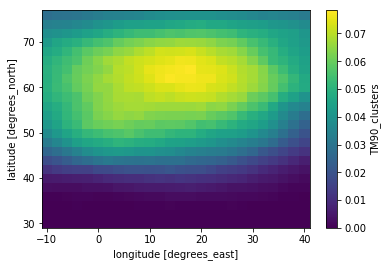

In [14]:
var_cluster_fin['TM90_clusters'].mean(axis=0).plot()

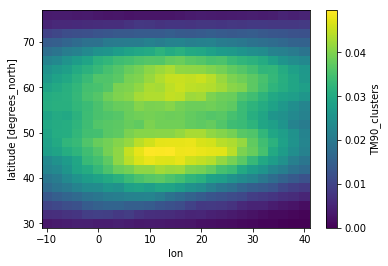

In [21]:
var_cluster_fin['TM90_clusters'].mean(axis=0).plot()

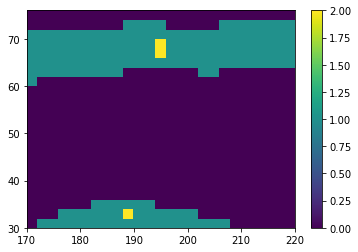

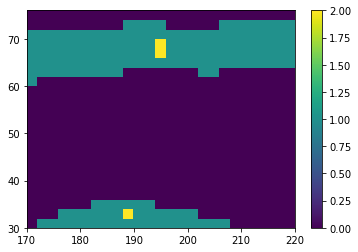

In [75]:
# time_samp = 19
# lat, lon = var_cluster_fin['lat'], var_cluster_fin['lon']
# var_bool_samp = var_cluster_fin['TM90_clusters'][time_samp,:,:]
# var_bool_blocked_clusters_samp = var_bool_blocked_clusters['TM90_clusters'][time_samp,:,:]
# fig=plt.figure()
# plt.pcolormesh(lon, lat, var_bool_samp)
# plt.colorbar()
# fig=plt.figure()
# plt.pcolormesh(lon, lat, var_bool_blocked_clusters_samp)
# plt.colorbar()

In [52]:
#block_idx_xr_persis_overlap = overlap_contour_criterea(block_idx_xr_persis, block_idx_str, var_bool_blocked_clusters) # takes about a minute to run

In [92]:
    
    #maybe here calculate the centroid position of each cluster
    
    
#     block_arr_overlap = block_idx_xr_persis.copy()
#     for i, blocked in enumerate(blocked_vals_arr):
#         cluster_arr = calc_clusters(var_blocked_clusters[i,:,:], len_lat, len_lon)  
#     #if i < 50:
#         # measure if the previous day was blocked
#         if i == blocked_vals_arr.shape[0]-1: 
#             next_blocked = 0
#         else:
#             next_blocked = blocked_vals_arr[i+1]
#         if blocked == 1 and next_blocked == 1: #if both the day and the day after are blocked
#             #to measure contour overlap from the P19 paper - "join clusters that overlap by one grid box"
#             #note that we are using a lower grid resolution here (2x2 not 1x1), but also a lower time resolution (24-hr not 6-hr)
#             #check if two days have any overlapping indices by setting the arrays to boolean and summing them (thus including clusters and their central points)
#             var_blocked_clusters_sum=((var_blocked_clusters['TM90_clusters'][i,:,:] > 0)+1-1)+((var_blocked_clusters['TM90_clusters'][i+1,:,:] > 0)+1-1)
#             if (var_blocked_clusters_sum.where(var_blocked_clusters_sum == 2).sum() == 0):
#                 #no overlap between previous and next day
#                 #set current day to be not blocked
#                 #block_arr_overlap[block_idx_str][i] = 0
#                 var_blocked_clusters_corr[i,:,:] = 0
#             #to check if two days overlap quickly, add the two days
#             #there will be 2 in at least one index if they overlap
#             #subtract 1 from the resulting lat/lon array
#             #check if there are any positive values
            
# # #             pass


# #var_blocked_clusters['TM90_clusters']
            
#     return block_arr_overlap, var_blocked_clusters_corr

NameError: name 'block_idx_xr_persis_overlap' is not defined

In [77]:
#apply persistence criterea again to remove any chance of overlap
#block_idx_xr_persis_overlap_persis = persistence_criterea(block_idx_xr_persis_overlap, block_idx_str, persis_thresh, JJA_days)

In [158]:
#season = "JJA"
#after applying area, persistence overlap and persistence criterea, select the season of interest
#block_idx_xr_pop_seas = block_idx_xr_persis_overlap_persis.sel(time = np.isin(block_idx_xr_persis_overlap_persis['time.season'], "JJA"))

In [24]:
var_cluster_fin_JJA = var_cluster_fin.sel(time = np.isin(var_cluster_fin['time.season'], "JJA"))

In [29]:
var_cluster_fin_JJA_clim = var_cluster_fin_JJA['TM90_clusters'].mean(axis=0)

In [30]:
var_cluster_fin_JJA_clim

<xarray.DataArray 'TM90_clusters' (lat: 24, lon: 26)>
array([[0.0033  , 0.00363 , 0.00396 , ..., 0.00033 , 0.      , 0.      ],
       [0.006821, 0.007041, 0.007481, ..., 0.00121 , 0.00088 , 0.00044 ],
       [0.010561, 0.011441, 0.012321, ..., 0.00319 , 0.00253 , 0.00198 ],
       ...,
       [0.009681, 0.010451, 0.011661, ..., 0.013421, 0.012981, 0.012651],
       [0.00484 , 0.005501, 0.005391, ..., 0.008251, 0.008361, 0.008691],
       [0.0033  , 0.00363 , 0.00363 , ..., 0.005171, 0.005061, 0.005391]])
Coordinates:
  * lat      (lat) float32 30.0 32.0 34.0 36.0 38.0 ... 68.0 70.0 72.0 74.0 76.0
  * lon      (lon) float32 -10.0 -8.0 -6.0 -4.0 -2.0 ... 34.0 36.0 38.0 40.0

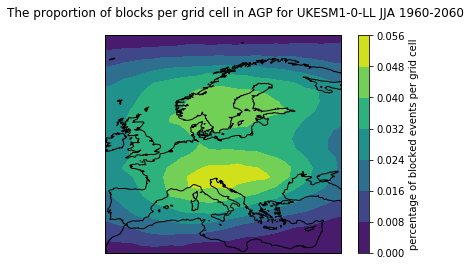

In [34]:
# prop_blocked_per_grid_cell=TM90_clusters.sum(axis=0)/3772
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines("50m")
clim = var_cluster_fin['TM90_clusters'].mean(axis=0)

llons, llats = np.meshgrid(var_cluster_fin['lon'], var_cluster_fin['lat'])
cs = ax.contourf(llons, llats, var_cluster_fin_JJA_clim)
fig.suptitle("The proportion of blocks per grid cell in AGP for UKESM1-0-LL JJA 1960-2060")

fig.colorbar(cs, label = "percentage of blocked events per grid cell")
#fig.tight_layout()
fig.savefig("/rds/general/user/cmt3718/home/plots/prop_blocked/prop_blocked_AGP_UKESM1-0-LL_JJA_1979-2019.png", dpi = 300, bbox_inches="tight")